In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload 
%autoreload 2

import scipy.stats
import numpy as np

# The model and simulations.

To match with the INLA notation, the $\theta$ parameter for Berry et al 2013 is called $x$ here. Also, Berry uses:
\begin{equation}
\tilde{x} = logit(p) - logit(p_1)
\end{equation}
whereas we use:
\begin{equation}
x = logit(p) = \tilde{x} + logit(p_1)
\end{equation}

In [2]:
p0 = np.full(4, 0.1) # rate of response below this is the null hypothesis
p1 = np.full(4, 0.3) # rate of response above this is the alternative hypothesis.
# rate of response > p0 and < p1 is gray area.
p0_theta = scipy.special.logit(p0)

pmid = (p0 + p1) / 2
pmid_theta = scipy.special.logit(pmid)

 # final evaluation criterion 
 # accept the alternative hypo if Pr(p[i] > p0|data) > pfinal_thresh[i]
pfinal_thresh = np.full(4, 0.85)

# early stopping criterion
pmid_accept = 0.9
pmid_fail = 0.05

null_x_berry = np.log(p0 / (1 - p0)) - np.log(p1 / (1 - p1))
null_x = np.log(p0 / (1 - p0))
prior_mu_mean = null_x[0]

In [3]:

def berry_prior(theta):
    mu = theta[..., 0]
    mu_prior = scipy.stats.norm.logpdf(mu, prior_mu_mean, 100)

    sigma2 = theta[..., 1]
    alpha = 0.0005
    beta = 0.000005
    sigma2_prior = scipy.stats.invgamma.logpdf(sigma2, alpha, scale=beta)
    return mu_prior + sigma2_prior

In [4]:
import inla

# I got this data by deconstructing the graphs in in Figure 1 of Berry et al 2013.
n_i = np.array([[i] * 4 for i in [10, 15, 20, 25, 30, 35]])
y_i = np.array(
    [
        [1, 6, 3, 3],
        [3, 8, 5, 4],
        [6, 9, 7, 5],
        [7, 10, 8, 7],
        [8, 10, 9, 8],
        [11, 11, 10, 9],
    ]
)
data = np.stack((y_i, n_i), axis=2)

model = inla.binomial_hierarchical()
model.log_prior = berry_prior

mu_rule = inla.simpson_rule(43, -1.5, -1.0)
sigma2_rule = inla.composite_simpson_rule(
    (9, 1e-7, 1e-6),
    (9, 1e-6, 1e-5),
    (9, 1e-5, 1e-4),
    (9, 1e-4, 1e-3),
    (9, 1e-3, 1e-2),
    (9, 1e-2, 1e-1),
    (9, 1e-1, 1e0),
)


In [5]:
scipy.special.expit(null_x)

array([0.1, 0.1, 0.1, 0.1])

In [6]:
scipy.special.logit(0.01), scipy.special.logit(0.6)

(-4.59511985013459, 0.4054651081081642)

In [7]:
x_range=[-1.5, -1.0]
x_quad = inla.simpson_rule(13, *x_range)
x_quad[0], x_quad[1]

(array([-1.5       , -1.45833333, -1.41666667, -1.375     , -1.33333333,
        -1.29166667, -1.25      , -1.20833333, -1.16666667, -1.125     ,
        -1.08333333, -1.04166667, -1.        ]),
 array([0.01388889, 0.05555556, 0.02777778, 0.05555556, 0.02777778,
        0.05555556, 0.02777778, 0.05555556, 0.02777778, 0.05555556,
        0.02777778, 0.05555556, 0.01388889]))

In [8]:
grids = np.meshgrid(x_quad[0], x_quad[0], x_quad[0], x_quad[0], mu_rule[0], sigma2_rule[0], indexing='ij')

In [9]:
len(grids), grids[0].shape

(6, (13, 13, 13, 13, 43, 63))

In [10]:
grid_stack = np.stack([g.flatten() for g in grids], axis=1)
grid_stack.shape

(77371749, 6)

In [51]:
wts = (
    x_quad[1][:, None, None, None, None, None]
    * x_quad[1][None, :, None, None, None, None]
    * x_quad[1][None, None, :, None, None, None]
    * x_quad[1][None, None, None, :, None, None]
    * mu_rule[1][None, None, None, None, :, None]
    * sigma2_rule[1][None, None, None, None, None, :]
)
wts = wts.flatten()
wts.shape

(77371749,)

In [52]:
giant_grid_x = grid_stack[:, :4]
giant_grid_theta = grid_stack[:, 4:6]
joint_density = model.log_joint(model, giant_grid_x, data[0], giant_grid_theta)
joint_density

array([-42.32503524, -18.1161393 , -11.24620494, ..., -37.89656724,
       -38.30327067, -38.66136998])

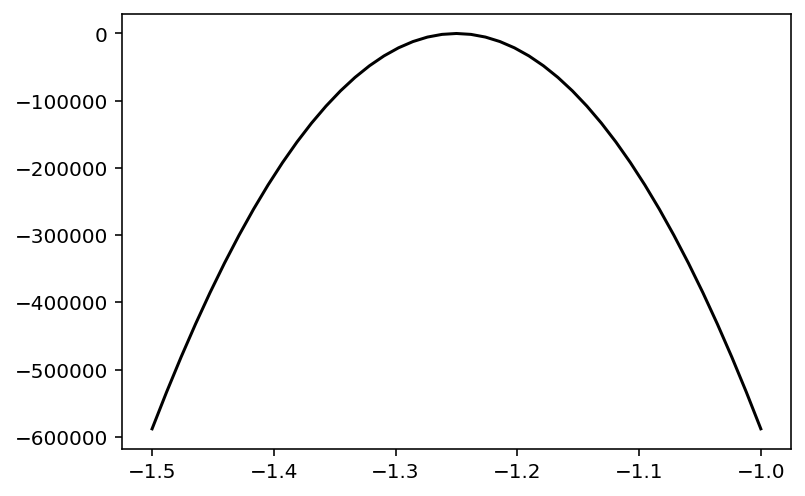

In [53]:
plt.plot(mu_rule[0], joint_density.reshape(grids[0].shape)[6,6,6,6,:,1], 'k-')
plt.show()

In [54]:
grids[0].shape

(13, 13, 13, 13, 43, 63)

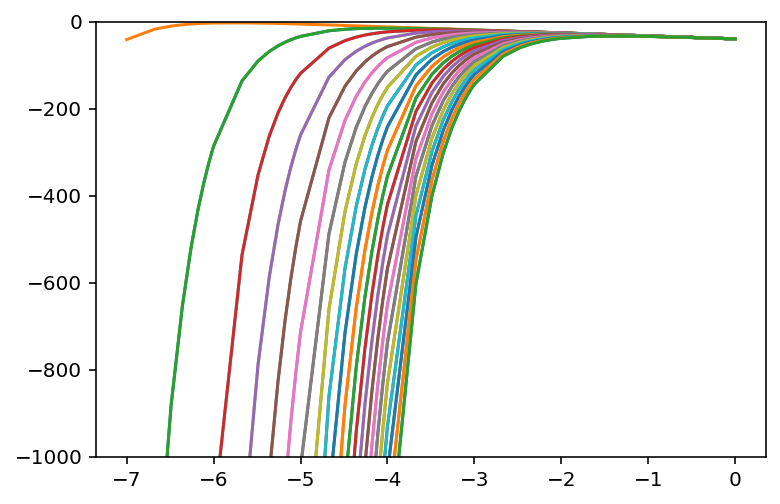

In [55]:
plt.plot(np.tile(np.log10(sigma2_rule[0])[None,:], (grids[0].shape[4],1)).T, joint_density.reshape(grids[0].shape)[6,6,6,6,:,:].T)
plt.ylim([-1000, 0])
plt.show()

In [56]:
max_x_idx = np.argmax(joint_density.reshape((-1, *grids[0].shape[4:6])), axis=0)
max_x0 = np.stack([g.reshape((-1, *grids[0].shape[4:6]))[max_x_idx, 0, 0] for g in grids[:4]], axis=2)


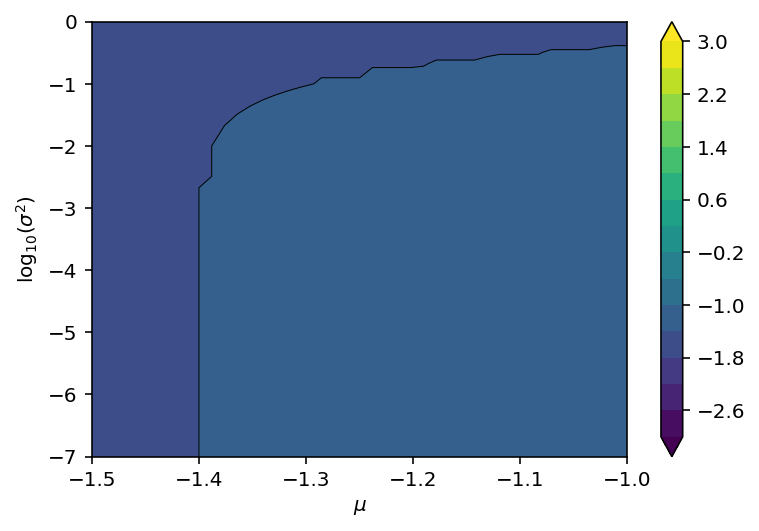

In [57]:
grid1 = grids[4][0,0,0,0]
grid2 = np.log10(grids[5][0,0,0,0])
field = max_x0[:,:,0]
levels = np.linspace(-3, 3, 16)

cntf = plt.contourf(
    grid1, grid2, field, levels=levels, extend="both"
)
plt.contour(
    grid1,
    grid2,
    field,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
cbar = plt.colorbar(cntf)
# cbar.set_label(None)
plt.xlabel("$\mu$")
plt.ylabel("$\log_{10} (\sigma^2)$")
plt.show()

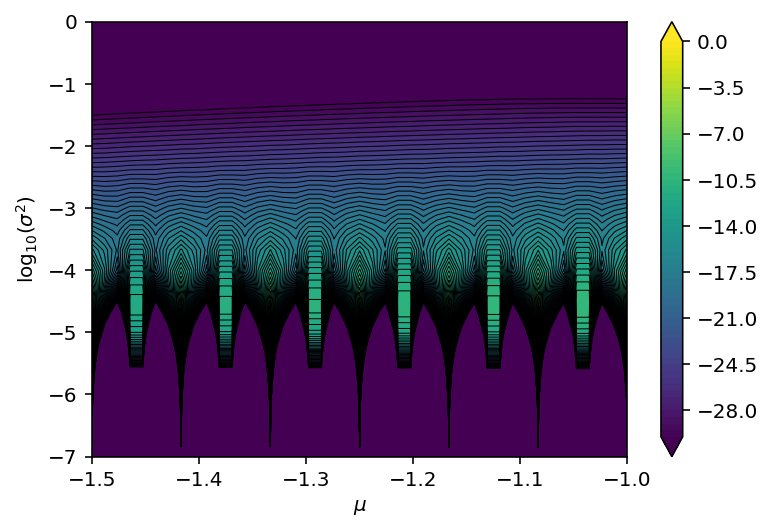

In [58]:
joint_density_x0 = np.diag(
    joint_density.reshape((-1, *grids[0].shape[4:6]))[max_x_idx].reshape(
        (grids[0].shape[4] * grids[0].shape[5], -1)
    )
).reshape(grids[0].shape[4:])
# joint_density_x0 = joint_density.reshape(grids[0].shape)[5,5,5,5,:,:]

grid1 = grids[4][0, 0, 0, 0]
grid2 = np.log10(grids[5][0, 0, 0, 0])
field = joint_density_x0
# field -= np.max(field)
# levels = np.linspace(np.max(field)-10, np.max(field), 21)
levels = np.linspace(-30, -0, 61)

cntf = plt.contourf(grid1, grid2, field, levels=levels, extend="both")
plt.contour(
    grid1,
    grid2,
    field,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
cbar = plt.colorbar(cntf)
# cbar.set_label(None)
plt.xlabel("$\mu$")
plt.ylabel("$\log_{10} (\sigma^2)$")
plt.show()

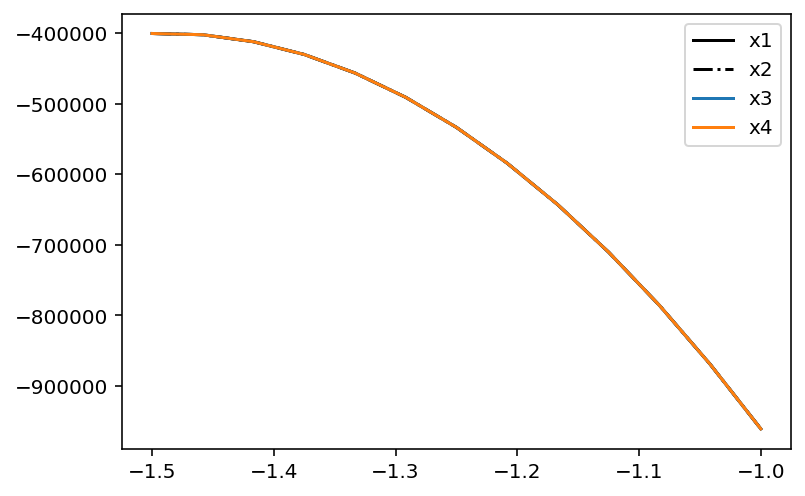

In [59]:
plt.plot(x_quad[0], joint_density.reshape(grids[0].shape)[:,6,6,6,1,1], 'k-', label='x1')
plt.plot(x_quad[0], joint_density.reshape(grids[0].shape)[6,:,6,6,1,1], 'k-.', label='x2')
plt.plot(x_quad[0], joint_density.reshape(grids[0].shape)[6,6,:,6,1,1], label='x3')
plt.plot(x_quad[0], joint_density.reshape(grids[0].shape)[6,6,6,:,1,1], label='x4')
plt.legend()
plt.show()

In [60]:
x0_marginal=np.sum(
    np.exp(joint_density.reshape(grids[0].shape))
    * x_quad[1][None, :, None, None, None, None]
    * x_quad[1][None, None, :, None, None, None]
    * x_quad[1][None, None, None, :, None, None]
    * mu_rule[1][None, None, None, None, :, None]
    * sigma2_rule[1][None, None, None, None, None, :],
    axis=(1,2,3,4,5)
)

In [61]:
sigma2_marginal=np.sum(
    np.exp(joint_density.reshape(grids[0].shape))
    * x_quad[1][:, None, None, None, None, None]
    * x_quad[1][None, :, None, None, None, None]
    * x_quad[1][None, None, :, None, None, None]
    * x_quad[1][None, None, None, :, None, None]
    * mu_rule[1][None, None, None, None, :, None]
    # * sigma2_rule[1][None, None, None, None, None, :],
    ,axis=(0,1,2,3,4)
)

In [62]:
sigma2_rule[0]

array([1.000e-07, 2.125e-07, 3.250e-07, 4.375e-07, 5.500e-07, 6.625e-07,
       7.750e-07, 8.875e-07, 1.000e-06, 1.000e-06, 2.125e-06, 3.250e-06,
       4.375e-06, 5.500e-06, 6.625e-06, 7.750e-06, 8.875e-06, 1.000e-05,
       1.000e-05, 2.125e-05, 3.250e-05, 4.375e-05, 5.500e-05, 6.625e-05,
       7.750e-05, 8.875e-05, 1.000e-04, 1.000e-04, 2.125e-04, 3.250e-04,
       4.375e-04, 5.500e-04, 6.625e-04, 7.750e-04, 8.875e-04, 1.000e-03,
       1.000e-03, 2.125e-03, 3.250e-03, 4.375e-03, 5.500e-03, 6.625e-03,
       7.750e-03, 8.875e-03, 1.000e-02, 1.000e-02, 2.125e-02, 3.250e-02,
       4.375e-02, 5.500e-02, 6.625e-02, 7.750e-02, 8.875e-02, 1.000e-01,
       1.000e-01, 2.125e-01, 3.250e-01, 4.375e-01, 5.500e-01, 6.625e-01,
       7.750e-01, 8.875e-01, 1.000e+00])

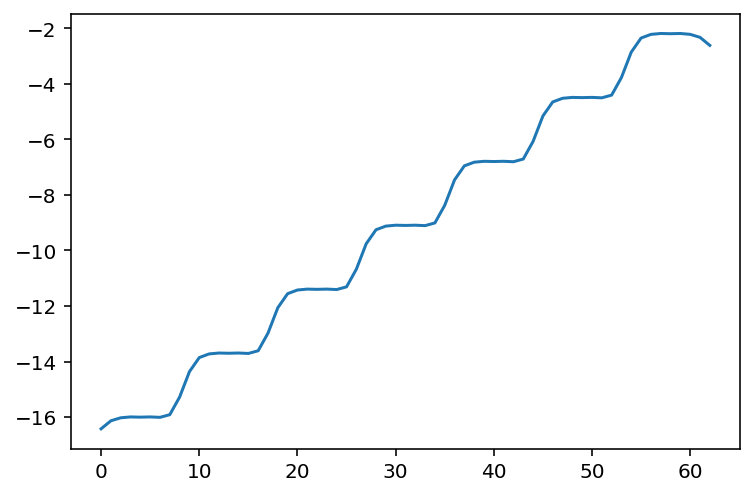

In [63]:
cell_volume = sigma2_rule[1][:, None]
cell_volume = scipy.ndimage.gaussian_filter(cell_volume, 1.0)
plt.plot(np.log(cell_volume))
plt.show()

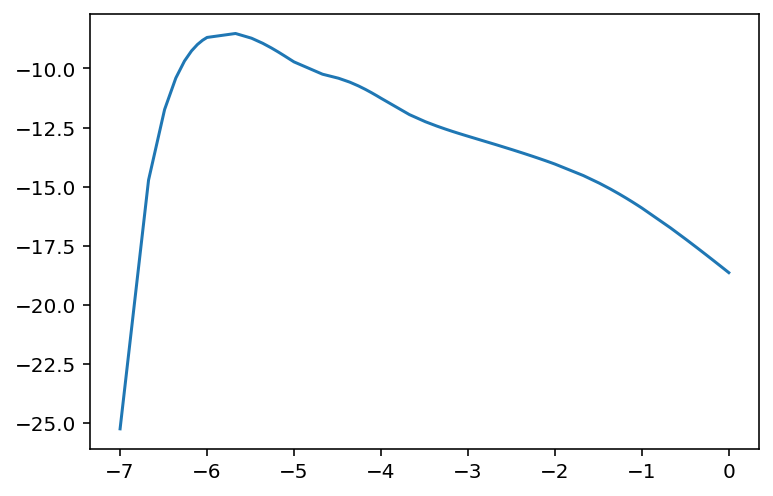

In [64]:
plt.plot(np.log10(sigma2_rule[0]), np.log10(sigma2_marginal))# + np.log10(cell_volume[:,0]))
plt.show()

In [65]:
np.exp(joint_density.max())

0.16161165367264893

In [66]:
joint_density_nonlog = np.exp(joint_density.reshape(grids[0].shape) + np.max(joint_density.max()))
mu_sig_marginal = np.sum(
    joint_density_nonlog 
    * x_quad[1][:, None, None, None, None, None]
    * x_quad[1][None, :, None, None, None, None]
    * x_quad[1][None, None, :, None, None, None]
    * x_quad[1][None, None, None, :, None, None]
    # * mu_rule[1][None, None, None, None, :, None]
    # * sigma2_rule[1][None, None, None, None, None, :],
    ,axis=(0,1,2,3)
)

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_43955/3953145316.py:3: RuntimeWarning: divide by zero encountered in log10
  field = np.log10(mu_sig_marginal)


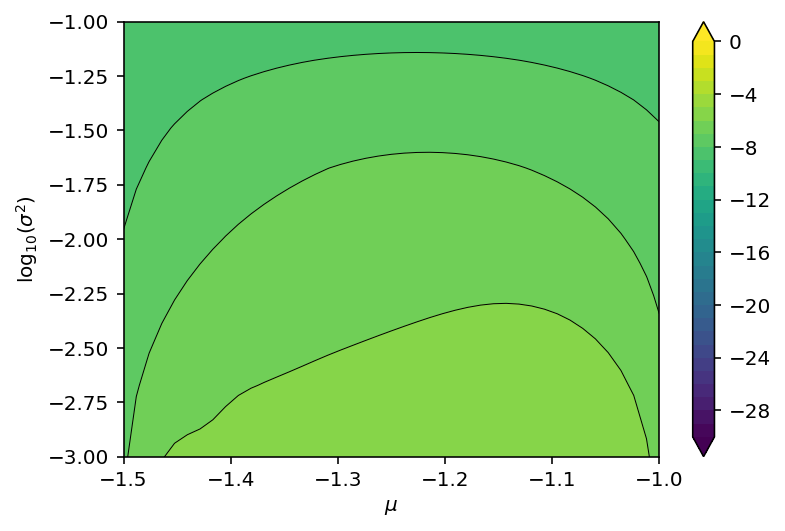

In [68]:
grid1 = grids[4][0,0,0,0]
grid2 = np.log10(grids[5][0,0,0,0])
field = np.log10(mu_sig_marginal)
field[np.isnan(field) | np.isinf(field)] = -280
field -= np.max(field)
levels = np.linspace(-30, 0, 31)

cntf = plt.contourf(
    grid1, grid2, field, levels=levels, extend="both"
)
plt.contour(
    grid1,
    grid2,
    field,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
cbar = plt.colorbar(cntf)
# cbar.set_label(None)
plt.xlabel("$\mu$")
plt.ylabel("$\log_{10} (\sigma^2)$")
plt.ylim([-3, -1])
plt.show()